In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [56]:
data = pd.read_csv("./steam-200k.csv", header = None, names=["id", "title", "action", "hours", "value"]) 

In [57]:
data.head()

,id,title,action,hours,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [58]:
data.describe()

,id,hours,value
count,2.000000e+05,200000.000000,200000.0
mean,1.036559e+08,17.874384,0.0
std,7.208074e+07,138.056952,0.0
min,5.250000e+03,0.100000,0.0
25%,4.738420e+07,1.000000,0.0
50%,8.691201e+07,1.000000,0.0
75%,1.542309e+08,1.300000,0.0
max,3.099031e+08,11754.000000,0.0


In [59]:
data = data.drop(columns=["value"])

In [60]:
data.id.nunique()

12393

In [ ]:
# тут посмотрим количество игр и количество покупок
num_games = data["title"].nunique()
num_purchases = data[data["action"] == "purchase"].shape[0]

num_games, num_purchases

(5155, 129511)

In [65]:
# выведем топ игр по времени, проведенном в них
playtime = data[data["action"] == "play"]
game_playtime = playtime.groupby("title")["hours"].sum().sort_values(ascending=False)

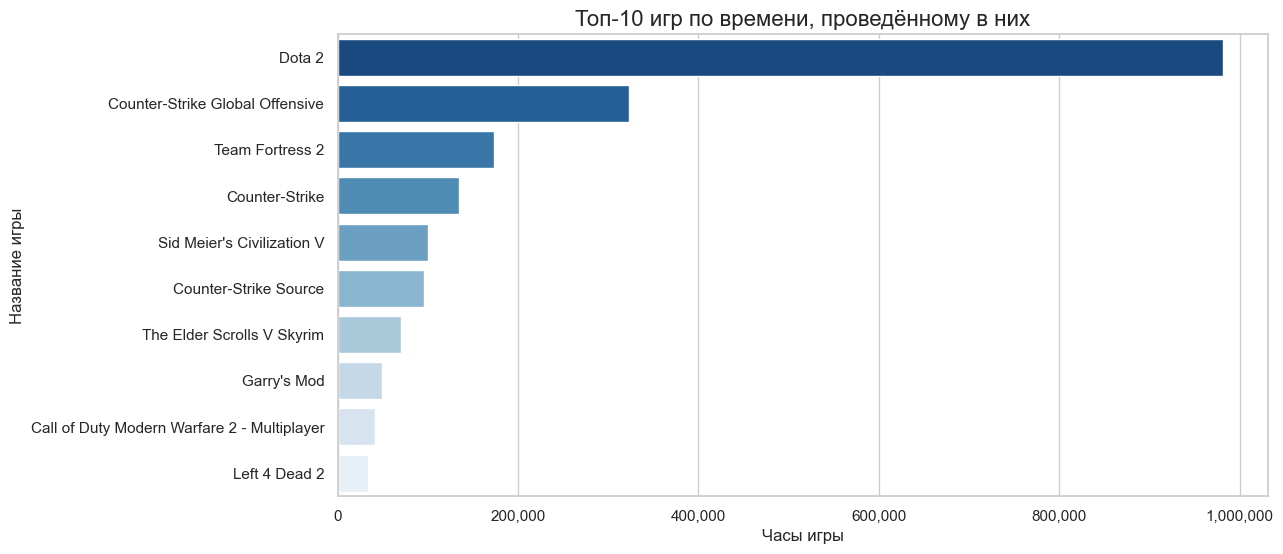

In [69]:
sns.set(style="whitegrid")

# группируем данные по играм и суммируем время, проведённое в них
game_playtime = playtime.groupby("title")["hours"].sum().sort_values(ascending=False).head(10)
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    x=game_playtime.values,
    y=game_playtime.index,
    ax=ax,
    palette="Blues_r" 
)

ax.set_title("Топ-10 игр по времени, проведённому в них", fontsize=16)
ax.set_xlabel("Часы игры", fontsize=12)
ax.set_ylabel("Название игры", fontsize=12)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.show()

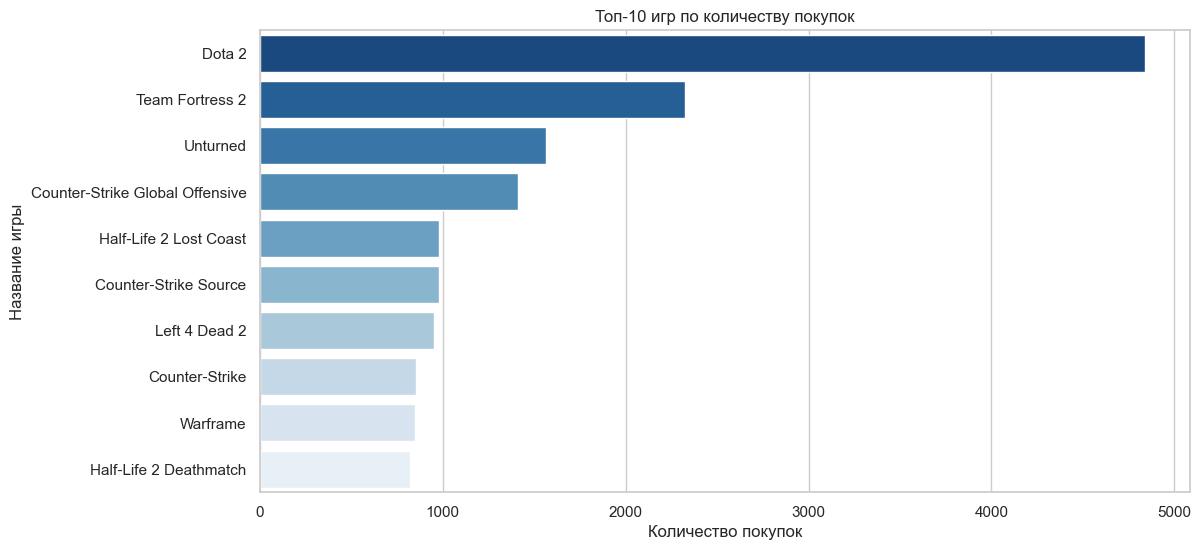

In [ ]:
sns.set(style="whitegrid")

# тут топ игр по покупкам
top_purchased_games = (
    data[data["action"] == "purchase"]["title"]
    .value_counts()
    .head(10)
)

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    x=top_purchased_games.values,
    y=top_purchased_games.index,
    ax=ax,
    palette="Blues_r"
)
ax.set_title("Топ-10 игр по количеству покупок")
ax.set_xlabel("Количество покупок")
ax.set_ylabel("Название игры")

plt.show()

In [ ]:
# оплаты и игры в пересчете на юзера
purchases_per_user = data[data["action"] == "purchase"].groupby("id").size()
playtime_per_user = data[data["action"] == "play"].groupby("id")["hours"].sum()

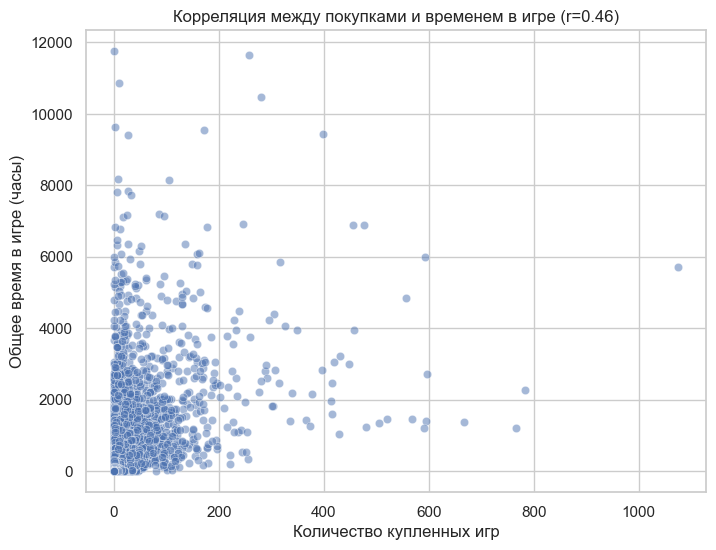

In [ ]:
correlation = purchases_per_user.corr(playtime_per_user)

fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(x=purchases_per_user, y=playtime_per_user, alpha=0.5, ax=ax)
ax.set_title(f"Корреляция между покупками и временем в игре (r={correlation:.2f})")
ax.set_xlabel("Количество купленных игр")
ax.set_ylabel("Общее время в игре (часы)")

plt.show()

In [ ]:
mean_playtime = playtime_per_user.mean()
median_playtime = playtime_per_user.median()

print(f"Среднее время игры на пользователя: {mean_playtime:.2f} часов")
print(f"Медианное время игры на пользователя: {median_playtime:.2f} часов")


Среднее время игры на пользователя: 303.56 часов
Медианное время игры на пользователя: 19.50 часов


In [ ]:
for threshold in [10, 50, 100]:
    percent = (playtime_per_user > threshold).mean() * 100
    print(f"Доля игроков, сыгравших более {threshold} часов: {percent:.2f}%")

# ретеншн и отток игроков
purchased_users = data[data["action"] == "purchase"]["id"].unique()
played_users = data[data["action"] == "play"]["id"].unique()
abandoned_users = set(purchased_users) - set(played_users)
churn_rate = len(abandoned_users) / len(purchased_users) * 100
print(f"Процент пользователей, которые купили игру, но не играли: {churn_rate:.2f}%")

Доля игроков, сыгравших более 10 часов: 57.96%
Доля игроков, сыгравших более 50 часов: 39.15%
Доля игроков, сыгравших более 100 часов: 31.87%
Процент пользователей, которые купили игру, но не играли: 8.42%


In [ ]:

playtime_per_game = data[data["action"] == "play"].groupby("title")["hours"].sum()
purchases_per_game = data[data["action"] == "purchase"]["title"].value_counts()

# cоотношение часов к покупкам игры
roi = (playtime_per_game / purchases_per_game).dropna().sort_values(ascending=False)

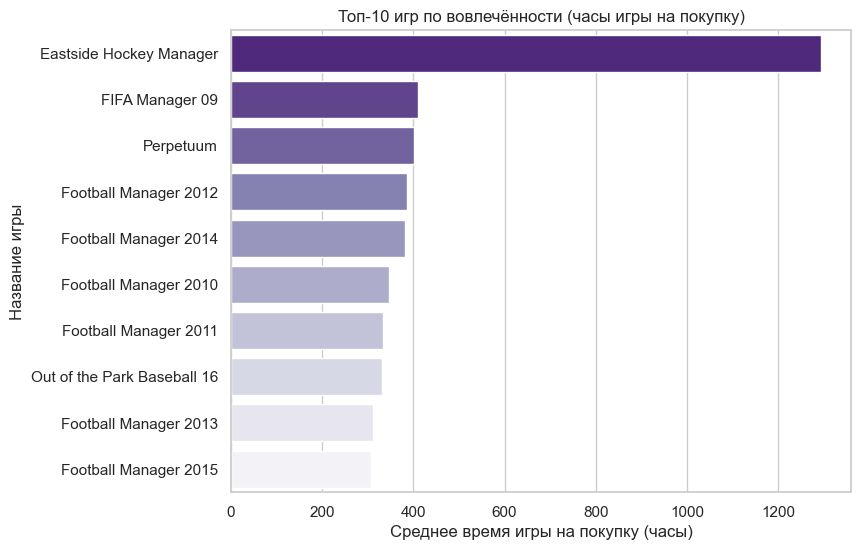

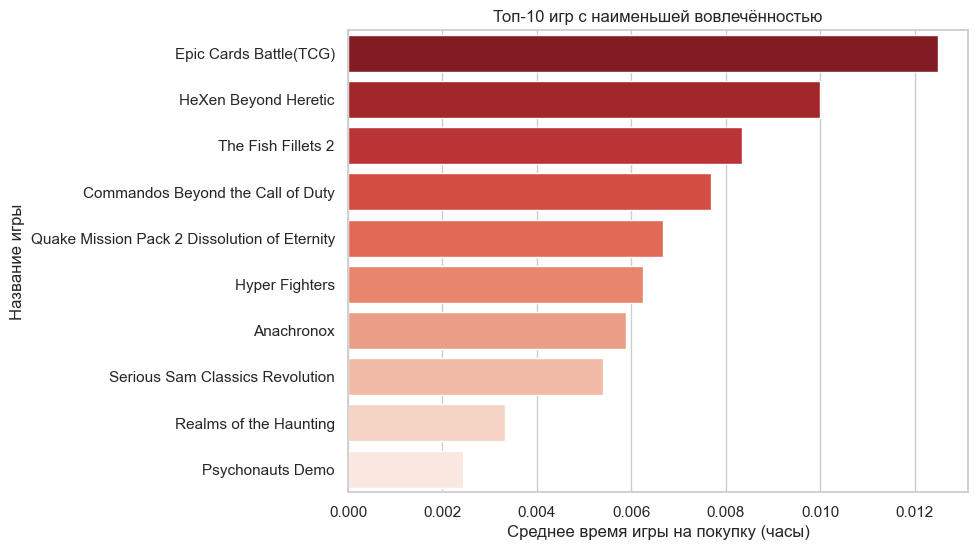

In [ ]:
# Топ-10 игр с наибольшим ROI
plt.figure(figsize=(8, 6))
sns.barplot(x=roi.head(10).values, y=roi.head(10).index, palette="Purples_r")
plt.title("Топ-10 игр по вовлечённости (часы игры на покупку)")
plt.xlabel("Среднее время игры на покупку (часы)")
plt.ylabel("Название игры")
plt.show()

# Топ-10 игр с наименьшим ROI (разочаровывающие игры)
plt.figure(figsize=(8, 6))
sns.barplot(x=roi.tail(10).values, y=roi.tail(10).index, palette="Reds_r")
plt.title("Топ-10 игр с наименьшей вовлечённостью")
plt.xlabel("Среднее время игры на покупку (часы)")
plt.ylabel("Название игры")
plt.show()

In [ ]:
popularity_vs_engagement = pd.DataFrame({
    "total_playtime": playtime_per_game,
    "total_purchases": purchases_per_game
}).dropna()

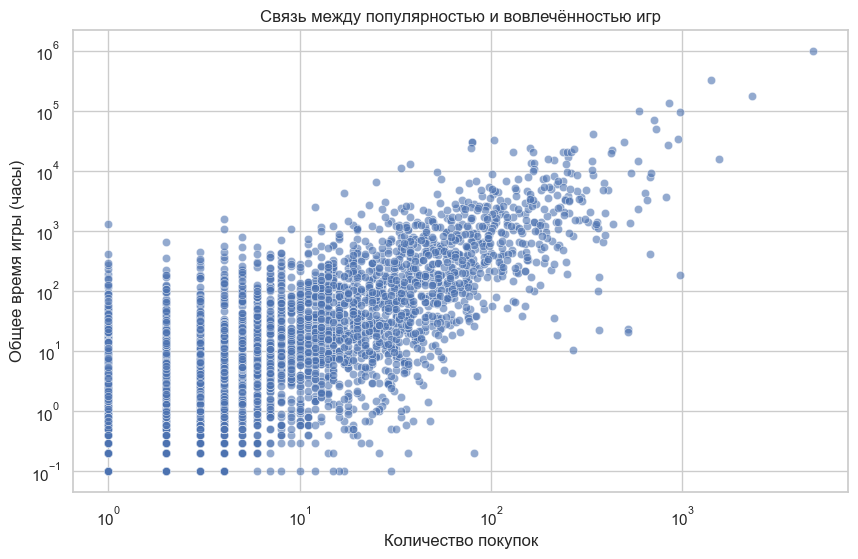

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=popularity_vs_engagement["total_purchases"], y=popularity_vs_engagement["total_playtime"], alpha=0.6)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Количество покупок")
plt.ylabel("Общее время игры (часы)")
plt.title("Связь между популярностью и вовлечённостью игр")
plt.show()

In [ ]:
user_stats = data.pivot_table(index="id", columns="action", values="hours", aggfunc="sum").fillna(0)
user_stats["purchase_count"] = data[data["action"] == "purchase"].groupby("id").size()

# Нормализация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_stats)

# Кластеризация K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_stats["cluster"] = kmeans.fit_predict(scaled_data)


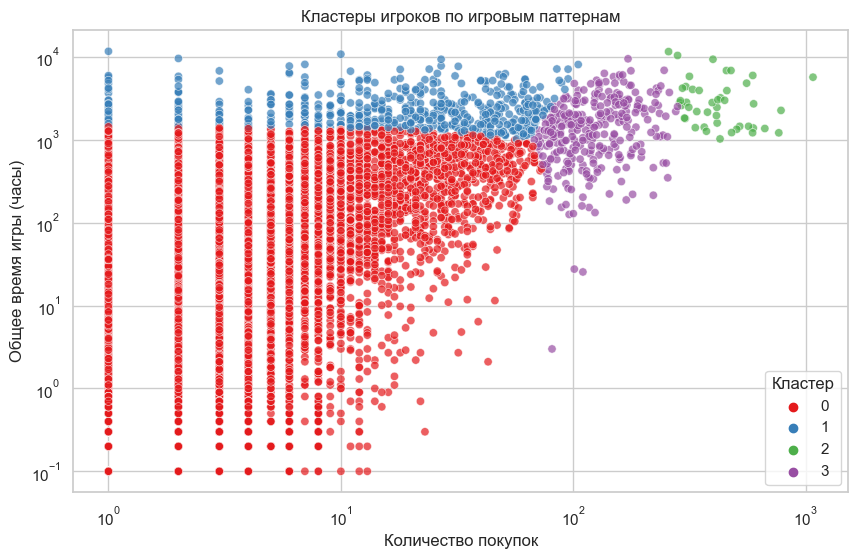

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=user_stats["purchase_count"], y=user_stats["play"], hue=user_stats["cluster"], palette="Set1", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Количество покупок")
plt.ylabel("Общее время игры (часы)")
plt.title("Кластеры игроков по игровым паттернам")
plt.legend(title="Кластер")
plt.show()

In [ ]:
if 'timestamp' in data.columns:
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data["month"] = data["timestamp"].dt.to_period("M")
    
    purchase_trends = data[data["action"] == "purchase"].groupby("month").size()
    playtime_trends = data[data["action"] == "play"].groupby("month")["hours"].sum()

    # График трендов покупок
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=purchase_trends.index.astype(str), y=purchase_trends.values, marker="o", label="Покупки")
    plt.xticks(rotation=45)
    plt.xlabel("Дата")
    plt.ylabel("Количество покупок")
    plt.title("Тренды покупок по времени")
    plt.legend()
    plt.show()


    # График трендов времени игры
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=playtime_trends.index.astype(str), y=playtime_trends.values, marker="o", label="Время игры (часы)", color='red')
    plt.xticks(rotation=45)
    plt.xlabel("Дата")
    plt.ylabel("Общее время игры (часы)")
    plt.title("Тренды игрового времени по времени")
    plt.legend()
    plt.show()